In [51]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
from tqdm import tqdm

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score , cohen_kappa_score, roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

- Ajustad un modelo de Decision Tree a nuestros datos.

- Calculad las métricas a nuestro nuevo modelo.

- Comparad las métricas con el modelo hecho hasta ahora. ¿Cuál es mejor?

## Decision Tree 1: Datos balanceados 50/50

In [43]:
#Cargamos nuestro dataframe, estandarizado, codificado y balanceados

df_travel_bal = pd.read_csv("data/df_travel_balanceado.csv", index_col=0)
df_travel_bal.sample(5)

,Unnamed: 0.1,Duration,Net Sales,Age,products,agency,country,Commision_oe,Agency Type_oe,Distribution Channel_Offline,Distribution Channel_Online,Claim
58574,32873,-0.466135,0.624116,-0.493090,1,2,0,1,1,0.0,1.0,1
32530,19355,-0.467893,2.063673,0.735010,0,1,0,1,0,0.0,1.0,0
11460,43479,3.122676,1.145352,-0.672769,0,0,0,1,1,0.0,1.0,0
17653,12745,0.014422,-1.084098,-0.270547,0,0,0,0,0,0.0,1.0,0
33075,25449,-0.182076,0.136791,-0.270547,0,0,0,0,0,0.0,1.0,0


In [44]:
df_travel_bal.drop('Unnamed: 0.1', axis = 1, inplace = True)

In [45]:
X = df_travel_bal.drop("Claim", axis = 1)
y = df_travel_bal["Claim"]

In [46]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [7]:
# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol = DecisionTreeClassifier(random_state =0)

# ajustamos el modelo, igual que en la regresión lienal. 
arbol.fit(x_train, y_train)

DecisionTreeClassifier(random_state=0)

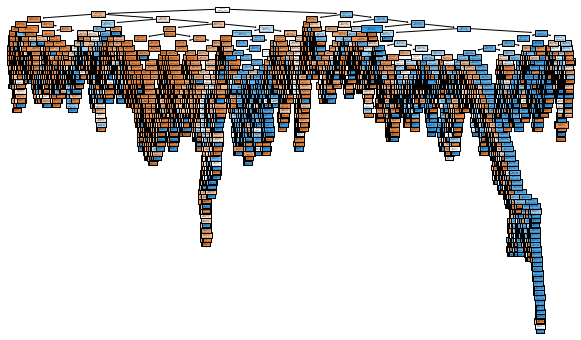

In [8]:
fig = plt.figure(figsize = (10,6))
tree.plot_tree(arbol, feature_names = x_train.columns.to_list(), filled = True)
plt.show()

In [9]:
# max features. Ponemos en nuestro modelo una profudidad máxima de 10. 

max_features = np.sqrt(len(x_train.columns))
max_features

3.1622776601683795

In [10]:
# max depth

print(arbol.tree_.max_depth)

67


In [11]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_esta = arbol.predict(x_test)
y_pred_train_esta = arbol.predict(x_train)

In [12]:
def metricas(clases_reales_test, clases_predichas_test, clases_reales_train, clases_predichas_train, modelo):
    
    # para el test
    accuracy_test = accuracy_score(clases_reales_test, clases_predichas_test)
    precision_test = precision_score(clases_reales_test, clases_predichas_test)
    recall_test = recall_score(clases_reales_test, clases_predichas_test)
    f1_test = f1_score(clases_reales_test, clases_predichas_test)
    kappa_test = cohen_kappa_score(clases_reales_test, clases_predichas_test)

    # para el train
    accuracy_train = accuracy_score(clases_reales_train, clases_predichas_train)
    precision_train = precision_score(clases_reales_train, clases_predichas_train)
    recall_train = recall_score(clases_reales_train, clases_predichas_train)
    f1_train = f1_score(clases_reales_train, clases_predichas_train)
    kappa_train = cohen_kappa_score(clases_reales_train, clases_predichas_train)
    

    
    df = pd.DataFrame({"accuracy": [accuracy_test, accuracy_train], 
                       "precision": [precision_test, precision_train],
                       "recall": [recall_test, recall_train], 
                       "f1": [f1_test, f1_train],
                       "kappa": [kappa_test, kappa_train],
                       "set": ["test", "train"]})
    
    df["modelo"] = modelo
    return df

In [14]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results = metricas(y_test, y_pred_test_esta, y_train, y_pred_train_esta, "Decission Tree I")
dt_results

,accuracy,precision,recall,f1,kappa,set,modelo
0,0.962899,0.969451,0.954926,0.962134,0.925772,test,Decission Tree I
1,0.998290,0.999908,0.996682,0.998292,0.996579,train,Decission Tree I


CONCLUSIONES:

El Kappa del train es tan cercano a 1 que consideramos que hay overfitting.

Vamos a limitar el Decision Tree

## Decision Tree 2: Datos balanceados 50/50 limitado

In [41]:
# lo primero que tenemos que hacer es definir un diccionario con los hiperparámetros que queremos modificar y los valores que queremos 

param = {"max_depth": [40, 50, 60], # nuestra profundidad era de 67
        "max_features": [1,2,3,4],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [50, 100, 150],
        "min_samples_leaf": [50,100,150]} 

In [16]:
## una vez creado el diccionario iniciaremos el modelo con GridSearch

gs = GridSearchCV(
            estimator=DecisionTreeClassifier(random_state= 42), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=0) # para que no nos printee ningún mensaje en pantalla

In [17]:
# ajustamos el modelo que acabamos de definir en el GridSearch

gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [40, 50, 60],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [50, 100, 150],
                         'min_samples_split': [50, 100, 150]})

In [18]:
# este método nos esta diciendo que el mejor modelo es aquel que tiene 
# una profundidad de 18, que usa 1 variable predictora para construir 
# el modelo y que tiene  un min_samples_leaf y un min_samples_split de 10. 
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeClassifier(max_depth=50, max_features=4, min_samples_leaf=50,
                       min_samples_split=50, random_state=42)

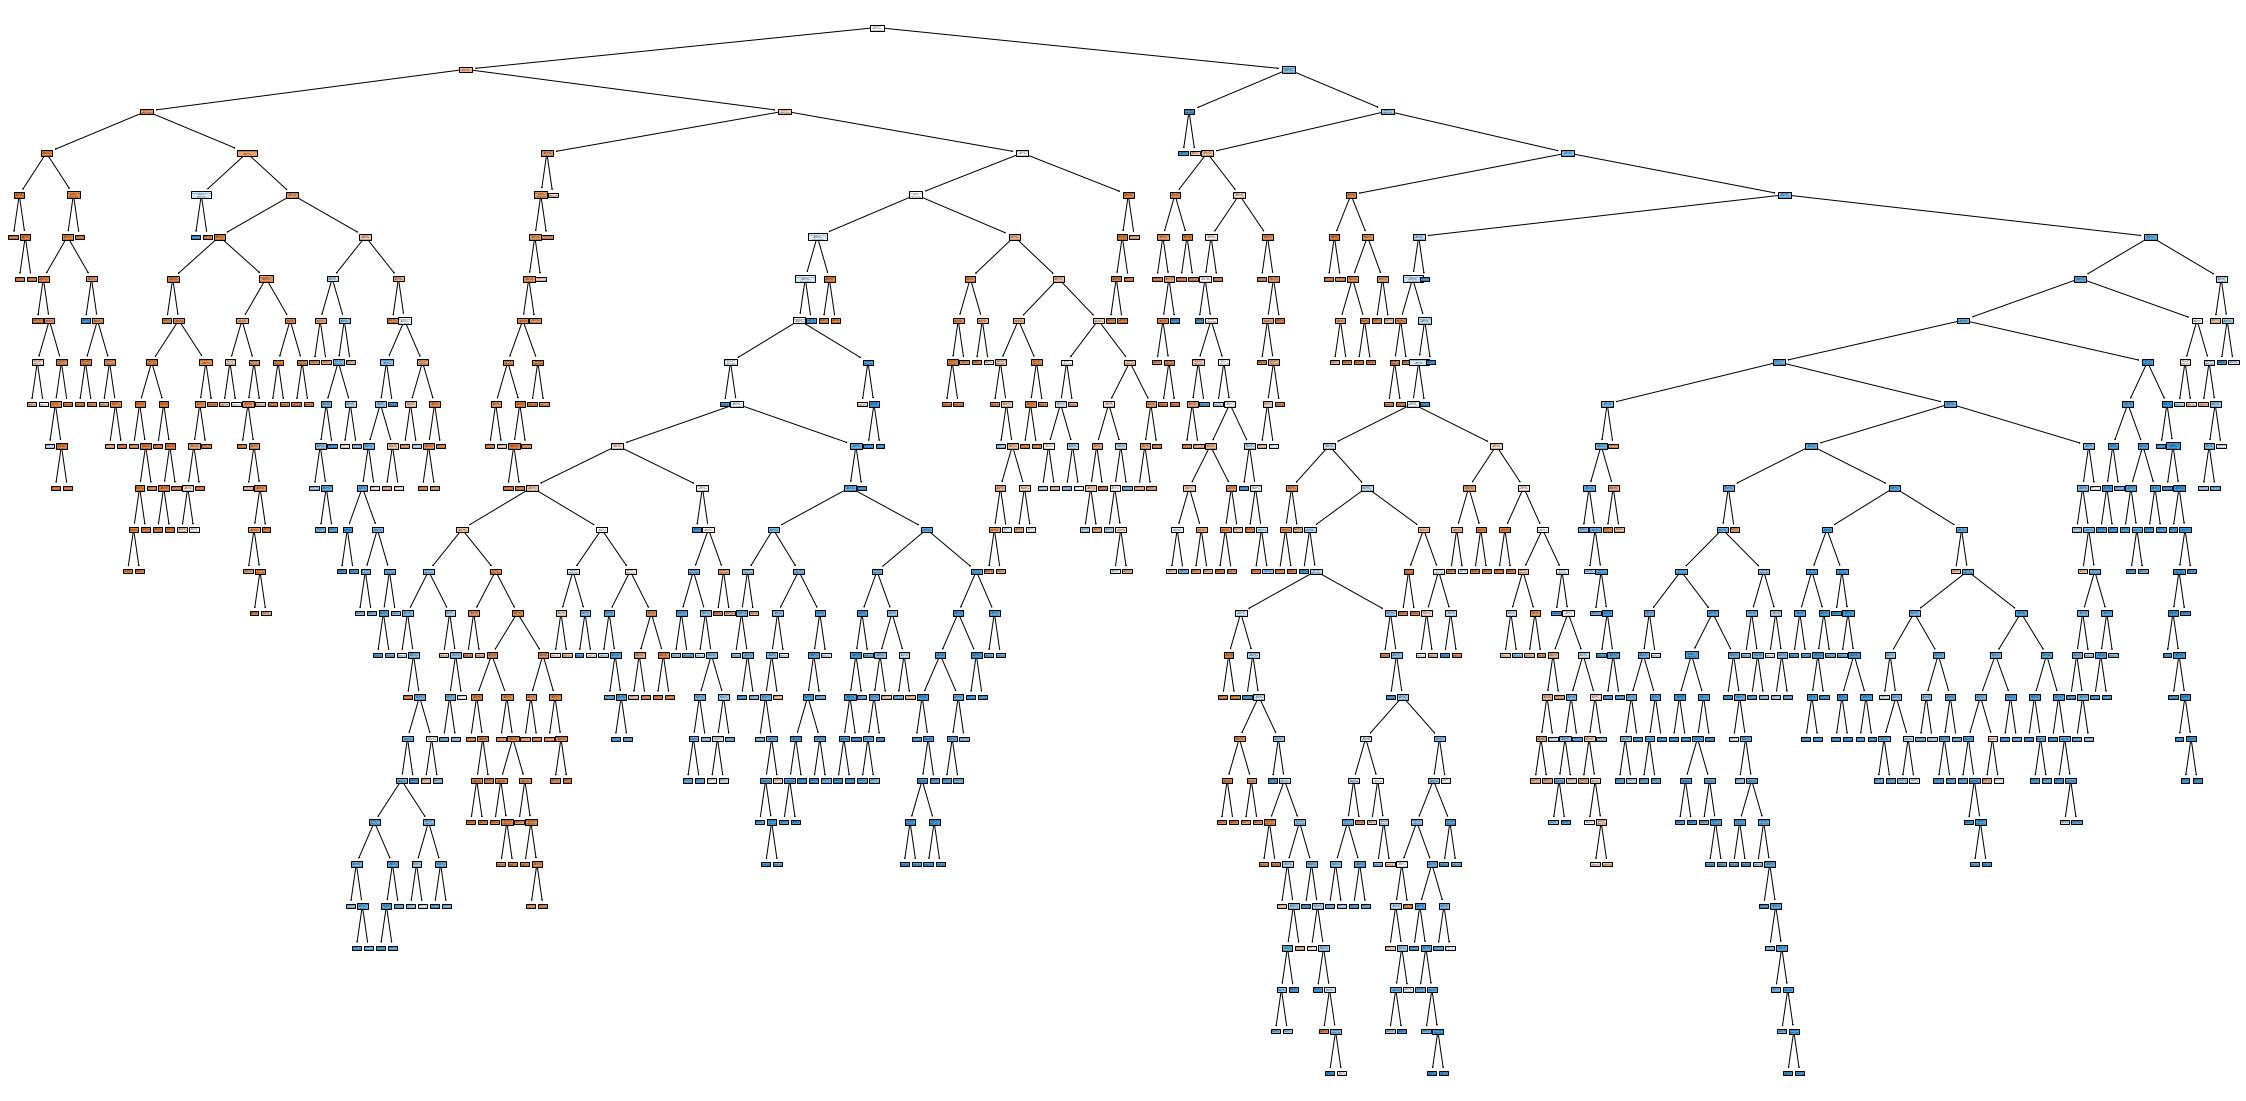

In [19]:
# veamos ahora que pinta tiene nuestro árbol

fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo, feature_names=x_train.columns.to_list(), filled=True);

In [20]:
#predecimos

y_pred_test_esta_cut = mejor_modelo.predict(x_test)
y_pred_train_esta_cut = mejor_modelo.predict(x_train)

In [22]:
dt_results_cut = metricas(y_test, y_pred_test_esta_cut, y_train,  y_pred_train_esta_cut, "Decision tree II")
dt_results_cut

,accuracy,precision,recall,f1,kappa,set,modelo
0,0.869161,0.867141,0.867899,0.867520,0.738281,test,Decision tree II
1,0.877488,0.880981,0.873810,0.877381,0.754981,train,Decision tree II


CONCLUSIONES:

Estas métricas salen mucho mejor, teniendo en cuenta que el kappa está por encima de 0.7 podemos decir que el modelo tiene éxito

Cogemos el dataframe con los datos estandarizados, codificados y balanceados y hacemos un Random Forest

In [42]:
#Usamos los mismos parámetros que hemos usado para el decision tree

gs_rf = GridSearchCV(
            estimator=RandomForestClassifier(random_state=42), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=0) # para que no nos printee ningún mensaje en pantalla
        

In [47]:
# ajustamos el modelo que acabamos de definir en el GridSearch
# 🚨 Esta celda puede tardar en ejecutarse

gs_rf.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [40, 50, 60],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [50, 100, 150],
                         'min_samples_split': [50, 100, 150]})

In [49]:
bosque = gs_rf.best_estimator_
bosque

RandomForestClassifier(max_depth=40, max_features=4, min_samples_leaf=50,
                       min_samples_split=50, random_state=42)

In [ ]:
# dibujemos los árboles de nuestro bosque

for arbol in tqdm(bosque.estimators_):
    fig = plt.figure(figsize=(20, 10))
    tree.plot_tree(arbol, feature_names= x_train.columns, filled = True)
    plt.show()

In [52]:
y_pred_test_rf = bosque.predict(x_test)
y_pred_train_rf = bosque.predict(x_train)

In [53]:

# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results_rf = metricas(y_test, y_pred_test_rf,y_train,  y_pred_train_rf, "Random Forest")
dt_results_rf


,accuracy,precision,recall,f1,kappa,set,modelo
0,0.891532,0.884459,0.897490,0.890927,0.783069,test,Random Forest
1,0.900447,0.897820,0.904466,0.901131,0.800887,train,Random Forest


CONCLUSIONES:

Los valores de estas métricas indican que nuestro modelo clasifica bien. 

Como los resultados del train son sólo ligeramente mejores que los del test podemos llegar a descartar el overfitting

Aún así podríamos intentar mejorar estas métricas.
